# JSON workflow test

In [22]:
from fsspec_reference_maker.hdf import SingleHdf5ToZarr 
from fsspec_reference_maker.combine import MultiZarrToZarr

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import s3fs
import logging
import fsspec
import json

from tqdm import tqdm
from glob import glob

In [23]:
fs = fsspec.filesystem('s3', anon=True)
urls = ['s3://' + f for f in fs.glob("s3://noaa-goes16/ABI-L2-SSTF/2020/210/*/*.nc")]

In [24]:
urls = []

so = dict(
        mode="rb", anon=True, default_fill_cache=False,
        default_cache_type="none"
)

for u in urls:
    with fsspec.open(u, **so) as inf:
        with open(f"../input/s3/{u.split('/')[-1]}", 'wb') as outf:
            outf.write(inf.read())


## Reading the individual files as Zarr with xarray

In [25]:
json_list = sorted(glob("../output/s3/*.json"))

In [26]:
m_list = []

for js in tqdm(json_list):
    with open(js) as f:
        m_list.append(fsspec.get_mapper("reference://", 
            fo=json.load(f), remote_protocol="file"))

100%|██████████| 25/25 [00:00<00:00, 84.49it/s] 


In [27]:
ds = xr.open_mfdataset(m_list, combine='nested', concat_dim='t',
                       engine='zarr', coords='minimal', 
                       data_vars='minimal', compat='override')

/opt/conda/lib/python3.9/site-packages/xarray/backends/api.py:908: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datasets = [open_(p, **open_kwargs) for p in paths]
/opt/conda/lib/python3.9/site-packages/xarray/backends/api.py:908: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_met

## Making a combined JSON file

In [28]:
fs = fsspec.filesystem(
    "reference", 
    fo="../output/s3/combined.json", 
    remote_protocol="file",
    skip_instance_cache=True
)
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine='zarr')

/tmp/ipykernel_67/2366355275.py:8: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_dataset(m, engine='zarr')


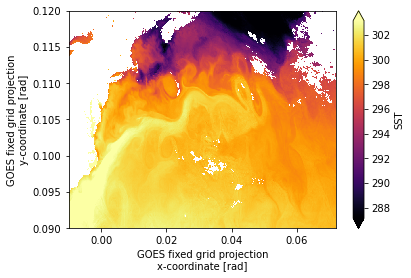

In [29]:
subset = ds.sel(x=slice(-0.01,0.07215601),y=slice(0.12,0.09))  #reduce to GS region
masked = subset.SST.where(subset.DQF==0)
masked.mean("t", skipna=True).plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')